In [9]:
from mmdet.apis import init_detector, inference_detector
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import matplotlib.colors as mcolors
import json

In [4]:
config = '../mmdet/configs/voc_tood.py'
checkpoint = 'checkpoints/voc_tood.pth'
device = 'cuda:0'

In [5]:
model = init_detector(config, checkpoint, device)

load checkpoint from local path: checkpoints/voc_tood.pth


2022-08-22 14:06:17,472 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-08-22 14:06:17,474 - root - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-08-22 14:06:17,476 - root - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-08-22 14:06:17,478 - root - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-08-22 14:06:17,480 - root - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-08-22 14:06:17,483 - root - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-08-22 14:06:17,486 - root - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-08-22 14:06:17,488 - root - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-08-22 14:06:17,490 - root - INFO - ModulatedDeformConvPack backbone.layer3.4.conv2 

In [115]:
color_map = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

def read_segmentation_map(im_path):
    seg_im = cv2.imread(im_path)
    seg_im = cv2.cvtColor(seg_im, cv2.COLOR_BGR2RGB)
    
    height, width = seg_im.shape[:2]
    segmentation_mask = np.zeros((height, width, len(color_map)), dtype=np.float32)
    for label_index, label in enumerate(color_map):
          segmentation_mask[:, :, label_index] = np.all(seg_im==label, axis=-1).astype(float)
    return segmentation_mask[:,:,1:]

def coco_to_box(box):
    return [box[0], box[1], box[0]+box[2], box[1]+box[3]]

In [74]:
PALETTE = [(106, 0, 228), (119, 11, 32), (165, 42, 42), (0, 0, 192),
               (197, 226, 255), (0, 60, 100), (0, 0, 142), (255, 77, 255),
               (153, 69, 1), (120, 166, 157), (0, 182, 199), (0, 226, 252),
               (182, 182, 255), (0, 0, 230), (220, 20, 60), (163, 255, 0),
               (0, 82, 0), (3, 95, 161), (0, 80, 100), (183, 130, 88)]

cmaps = []
for ic in range(len(PALETTE)):
    colors = [(PALETTE[ic][0], PALETTE[ic][1], PALETTE[ic][2], c) for c in np.linspace(0,1,100)]
    cmaps.append( mcolors.LinearSegmentedColormap.from_list(f'mycmap{ic}', colors, N=5) )

In [21]:
with open('data/voc_test/voc07_test.json', 'r') as f:
    ann_det = json.load(f)

In [133]:
id_dict = {
    0 : 'aeroplane',
    1 : 'bicycle',
    2 : 'bird',
    3 : 'boat',
    4 : 'bottle',
    5 : 'bus',
    6 : 'car',
    7 : 'cat',
    8 : 'chair',
    9 : 'cow',
    10 : 'diningtable',
    11 : 'dog',
    12 : 'horse',
    13 : 'motorbike',
    14 : 'person',
    15 : 'pottedplant',
    16 : 'sheep',
    17 : 'sofa',
    18 : 'train',
    19 : 'tvmonitor',
}

In [63]:
def generate_mask(image_size, grid_size, prob_thresh):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

In [64]:
def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) *
              255).astype(np.uint8)
    return masked

In [65]:
def iou(boxes, box):
    box = np.asarray(box)
    tl = np.maximum(boxes[:,:2], box[:2])
    br = np.minimum(boxes[:,2:], box[2:])
    intersection = np.prod(br - tl, axis=1) * np.all(tl < br, axis=1).astype(float)
    area1 = np.prod(boxes[:,2:] - boxes[:,:2], axis=1)
    area2 = np.prod(box[2:] - box[:2])
    return intersection / (area1 + area2 - intersection)

In [66]:
def generate_saliency_map(image,
                          n_classes,
                          target_boxes,
                          prob_thresh=0.5,
                          grid_size=(16, 16),
                          n_masks=5000,
                          seed=0):
    np.random.seed(seed)
    image_h, image_w = image.shape[:2]
    res = [
            [np.zeros((image_h, image_w), dtype=np.float32) for _ in range (len(target_boxes[ic]))]
            for ic in range(n_classes)
    ]
    for i in tqdm.notebook.tqdm(range(n_masks)):
        mask = generate_mask(image_size=(image_w, image_h),
                             grid_size=grid_size,
                             prob_thresh=prob_thresh)
        masked = mask_image(image, mask)
        out = inference_detector(model, masked)
        for ic in range(n_classes):
            boxes = target_boxes[ic]
            pred = out[ic]
            if len(pred) > 0 and len(boxes) > 0:
                score = np.stack([iou(boxes, box) * score for *box, score in pred]).max(axis=0)
                for ib in range(len(target_boxes[ic])):
                    res[ic][ib] += mask * score[ib]
    return res

[229, 113, 329, 220] 13
[4, 97, 221, 374] 13
[360, 114, 436, 264] 14
[0, 88, 37, 183] 14


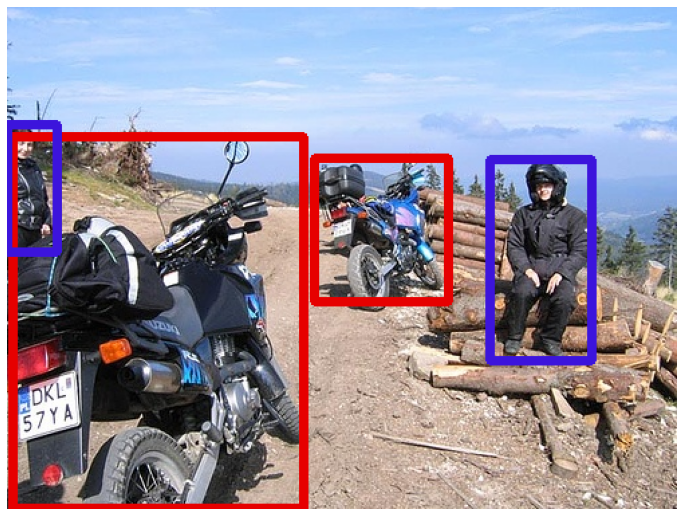

In [194]:
seg_path = f'data/voc_test/VOC2007/SegmentationClass/005354.png'
im_name = seg_path.split('/')[-1].replace('.png', '')
image_path = f'data/voc_test/VOC2007/JPEGImages/{im_name}.jpg'
image = cv2.imread(image_path)

res = image.copy()
target_boxes = [[] for _ in range(len(ann_det['categories']))]

for im in ann_det['images']:
    if im_name in im['file_name']:
        im_id = im['id']
        break

for ann in ann_det['annotations']:
    if ann['image_id'] == im_id:
        box = coco_to_box(ann['bbox'])
        cat = ann['category_id']
        print(box, cat)
        cv2.rectangle(res, box[:2], box[2:], PALETTE[cat], 5)
        target_boxes[cat].append(box)
            
plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.axis('off')
plt.show()

for ic, c in enumerate(target_boxes):
    if len(c) > 0:
        target_boxes[ic] = np.stack(c)
        
segmentation_map = read_segmentation_map(seg_path)     

13 (1, 103, 224, 374) 0.9661352
13 (226, 110, 326, 227) 0.7867259
14 (366, 114, 437, 264) 0.95279634
14 (0, 88, 34, 199) 0.7919803


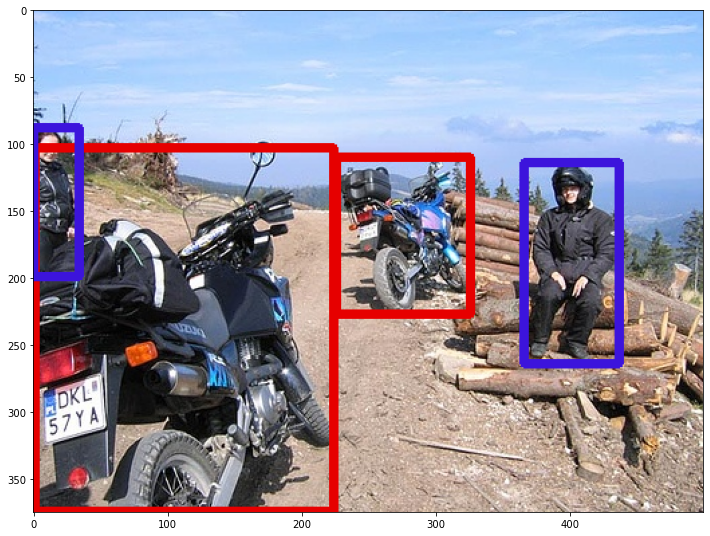

In [195]:
out = inference_detector(model, image)
res = image.copy()
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.3:
            continue
        box = tuple(np.round(box).astype(int).tolist())
        print(i, box, score)
        cv2.rectangle(res, box[:2], box[2:], PALETTE[i], 5)

plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

# Extract segmentation map with D-RISE

In [196]:
saliency_map = generate_saliency_map(image,
                                     n_classes=len(ann_det['categories']),
                                     target_boxes=target_boxes,
                                     prob_thresh=0.5,
                                     grid_size=(16, 16),
                                     n_masks=500)

  0%|          | 0/500 [00:00<?, ?it/s]

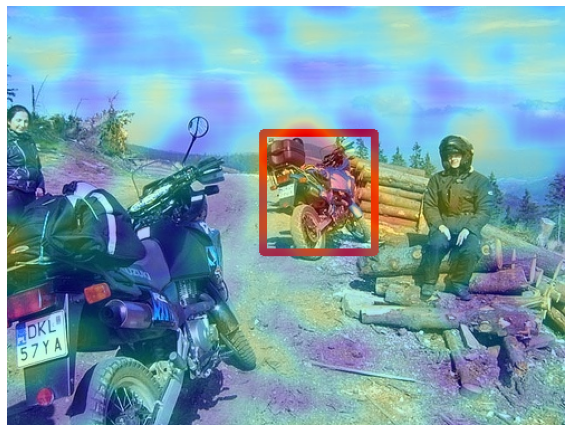

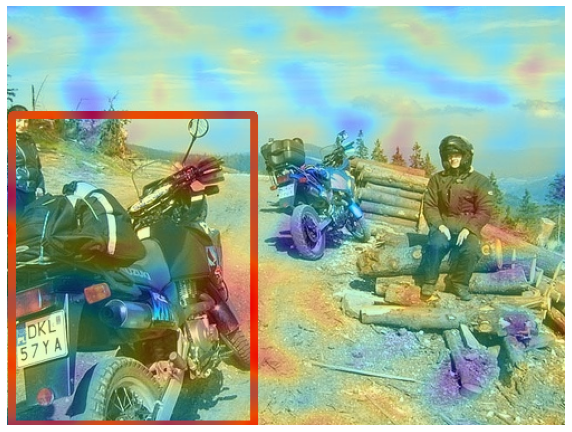

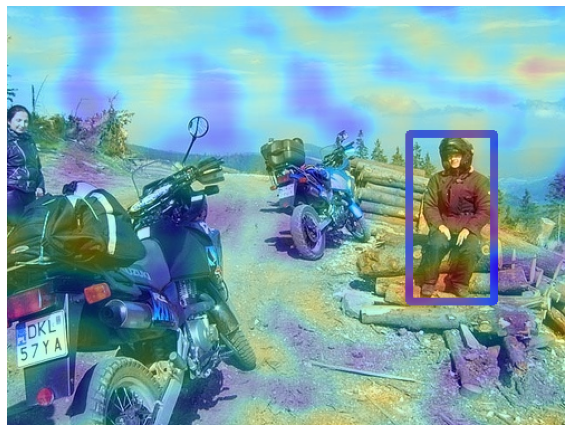

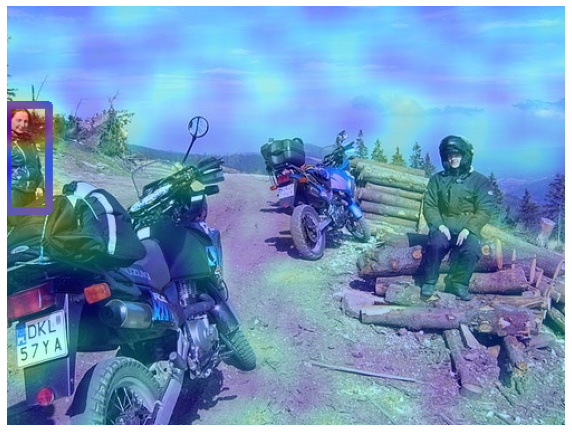

In [197]:
for ic, boxes in enumerate(target_boxes):
    for ib in range(len(boxes)):
        image_with_bbox = image.copy()
        cv2.rectangle(image_with_bbox, tuple(boxes[ib, :2]),
                      tuple(boxes[ib, 2:]), PALETTE[ic], 5)

        plt.figure(figsize=(10, 8))
        plt.imshow(image_with_bbox[:, :, ::-1])

        plt.imshow(saliency_map[ic][ib], cmap='jet', alpha=0.3)

        plt.axis('off')
        plt.show()

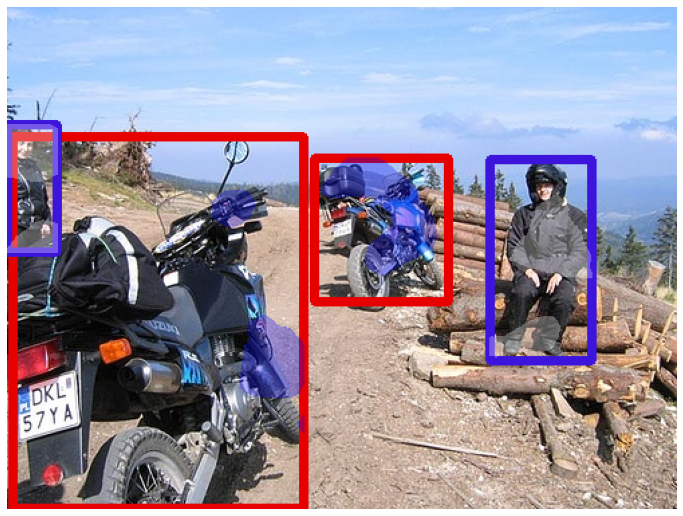

In [198]:
image_with_bbox = image.copy()
for ic in range(len(ann_det['categories'])):
    for i in range(len(target_boxes[ic])):
        cv2.rectangle(image_with_bbox, tuple(target_boxes[ic][i,:2]),
                      tuple(target_boxes[ic][i,2:]), PALETTE[ic], 5)
        
plt.figure(figsize=(12, 12))
plt.imshow(image_with_bbox[:, :, ::-1])

seg_map = []

for ic in range(len(ann_det['categories'])):
    seg_map_tmp = np.zeros((image.shape[0], image.shape[1])) # for annotation file
    
    if len(target_boxes[ic]) > 0:

        # keep segmentation map within annotated bboxes
        box_mask = np.full(saliency_map[ic][0].shape, False)
        for x1,y1,x2,y2 in target_boxes[ic]:
            box_mask[y1:y2+1, x1:x2+1] = True

        for ib in range(len(target_boxes[ic])):
            score_mask = saliency_map[ic][ib]>np.percentile(saliency_map[ic][ib], 98)
            segmentation_mask = score_mask & box_mask

            plt.imshow(segmentation_mask, cmap=cmaps[ic], alpha=0.3)
#            seg_map_tmp = np.where(segmentation_mask, ic+1, seg_map_tmp) # for annotation file
            seg_map_tmp = np.where(segmentation_mask, 1, seg_map_tmp) # for annotation file

    seg_map.append(seg_map_tmp)

seg_map = np.stack(seg_map, axis=2)

plt.axis('off')
plt.show()

# Annotated segmentation map

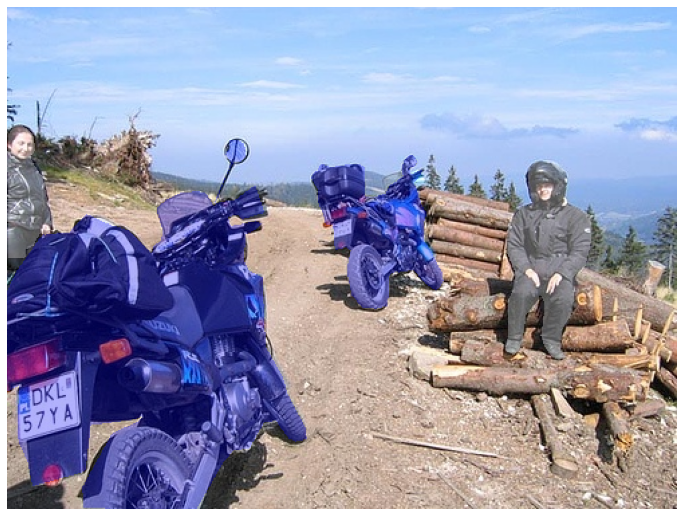

In [199]:
image_with_map = image.copy()
        
plt.figure(figsize=(12, 12))
plt.imshow(image_with_map[:, :, ::-1])

for ic in range(len(ann_det['categories'])):
    if segmentation_map[:,:,ic].sum() == 0:
        continue

    plt.imshow(segmentation_map[:,:,ic], cmap=cmaps[ic], alpha=0.3)
    
plt.axis('off')
plt.show()

# Compare annotated and extracted maps

In [200]:
for ic in range(len(ann_det['categories'])):
    if segmentation_map[:,:,ic].sum() == 0:
        continue
        
    union = ((seg_map[:,:,ic] + segmentation_map[:,:,ic]) > 0).sum()
    intersection = ((seg_map[:,:,ic] + segmentation_map[:,:,ic]) > 1).sum()
    
    print(id_dict[ic], 'IoU =', intersection / union)

motorbike IoU = 0.10013499390350113
person IoU = 0.38858695652173914
